In [1]:
import numpy as np
import time
from sklearn.cluster import KMeans

# Function to generate a Zipf's law distribution
def generate_zipf_distribution(n, a=1.5):
    ranks = np.arange(1, n+1)
    weights = 1 / ranks**a
    distribution = weights / weights.sum()
    return distribution

# Function to reduce the distribution size using clustering
def reduce_distribution(p, m):
    start_time = time.time()
    
    n = len(p)
    # Reshape for clustering
    p_reshaped = p.reshape(-1, 1)
    
    # Apply KMeans clustering
    kmeans = KMeans(n_clusters=m, random_state=42)
    kmeans.fit(p_reshaped)
    
    # Aggregate probabilities within clusters
    q = np.zeros(m)
    for i in range(m):
        cluster_indices = np.where(kmeans.labels_ == i)[0]
        q[i] = p[cluster_indices].sum()
    
    # Ensure q is a valid probability distribution
    q /= q.sum()
    
    end_time = time.time()
    runtime = end_time - start_time
    
    return q, runtime

# Main script
if __name__ == "__main__":
    n = 30000  # Original number of entries
    m = 20000  # Reduced number of entries
    exponent = 2.5  # Exponent used in the sum
    
    # Generate the original Zipf's law distribution
    p = generate_zipf_distribution(n)
    
    # Compute the original sum of entries raised to the exponent
    S_p = np.sum(p ** exponent)
    
    # Reduce the distribution size
    q, runtime = reduce_distribution(p, m)
    
    # Compute the reduced sum
    S_q = np.sum(q ** exponent)
    
    # Compute the error
    error = abs(S_p - S_q)
    
    # Print the results
    print(f"Original sum (S_p): {S_p}")
    print(f"Reduced sum (S_q): {S_q}")
    print(f"Absolute error: {error}")
    print(f"Runtime for reduction: {runtime:.4f} seconds")
    print(f"Does this even make sense as a goal??")

Original sum (S_p): 0.1009996581868419
Reduced sum (S_q): 0.10099965818721196
Absolute error: 3.700650896831803e-13
Runtime for reduction: 20.4219 seconds


Wasserstein distance between original and reduced distributions: 0.6197138489534452
Runtime for reduction: 0.0188 seconds


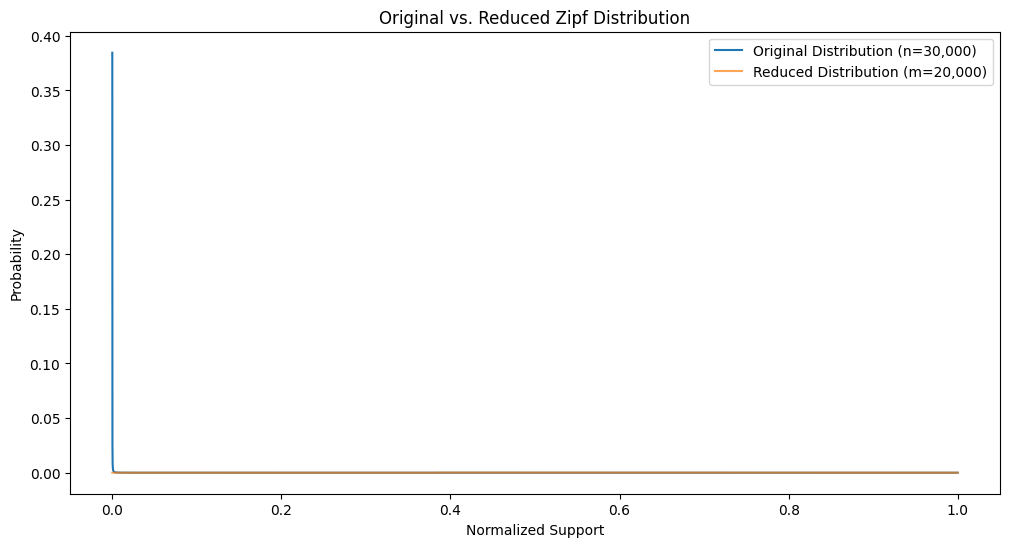

In [5]:
import numpy as np
import time
import matplotlib.pyplot as plt
from scipy.stats import wasserstein_distance

# Function to generate a Zipf's law distribution
def generate_zipf_distribution(n, a=1.5):
    ranks = np.arange(1, n + 1)
    weights = 1 / ranks**a
    distribution = weights / weights.sum()
    return distribution

# Function to reduce the distribution size using quantization
def reduce_distribution_quantization(p, m):
    start_time = time.time()

    n = len(p)
    # Compute the cumulative distribution function (CDF)
    cdf_p = np.cumsum(p)

    # Compute quantiles corresponding to the desired number of points
    quantiles = np.linspace(0, 1, m + 1)

    # Find bin edges in the original distribution corresponding to these quantiles
    bin_edges = np.interp(quantiles, cdf_p, np.arange(n))

    # Initialize the reduced distribution
    q = np.zeros(m)

    for i in range(m):
        # Left and right edges of the bin
        left_edge = bin_edges[i]
        right_edge = bin_edges[i + 1]

        # Indices of the original distribution that fall into the current bin
        left_idx = int(np.floor(left_edge))
        right_idx = int(np.floor(right_edge))

        # Handle edge cases
        if left_idx == right_idx:
            # Entire bin falls within a single original index
            q[i] = p[left_idx] * (right_edge - left_edge)
        else:
            # Add the fractional part from the left edge
            q[i] += p[left_idx] * (1 - (left_edge - left_idx))
            # Add full probabilities in between
            q[i] += p[left_idx + 1:right_idx].sum()
            # Add the fractional part from the right edge
            if right_idx < n:
                q[i] += p[right_idx] * (right_edge - right_idx)

    # Normalize to ensure q sums to 1
    q /= q.sum()

    end_time = time.time()
    runtime = end_time - start_time

    return q, runtime

n = 30000  # Original number of entries
m = 20000  # Reduced number of entries

# Generate the original Zipf's law distribution
p = generate_zipf_distribution(n)

# Reduce the distribution size
q, runtime = reduce_distribution_quantization(p, m)

# Supports (positions where the probabilities are located)
x_p = np.arange(n) / n  # Normalize support to [0, 1]
x_q = np.linspace(0, 1, m)  # Reduced support

# Compute the Wasserstein distance using SciPy
wd = wasserstein_distance(x_p, x_q, u_weights=p, v_weights=q)

# Print the results
print(f"Wasserstein distance between original and reduced distributions: {wd}")
print(f"Runtime for reduction: {runtime:.4f} seconds")

# Optional: Plot the original and reduced distributions
plt.figure(figsize=(12, 6))
plt.plot(x_p, p, label='Original Distribution (n=30,000)')
plt.plot(x_q, q, label='Reduced Distribution (m=20,000)', alpha=0.7)
plt.xlabel('Normalized Support')
plt.ylabel('Probability')
plt.title('Original vs. Reduced Zipf Distribution')
plt.legend()
plt.show()

Wasserstein distance between original and reduced distributions: 0.005809877561095364
Runtime for reduction: 0.0002 seconds


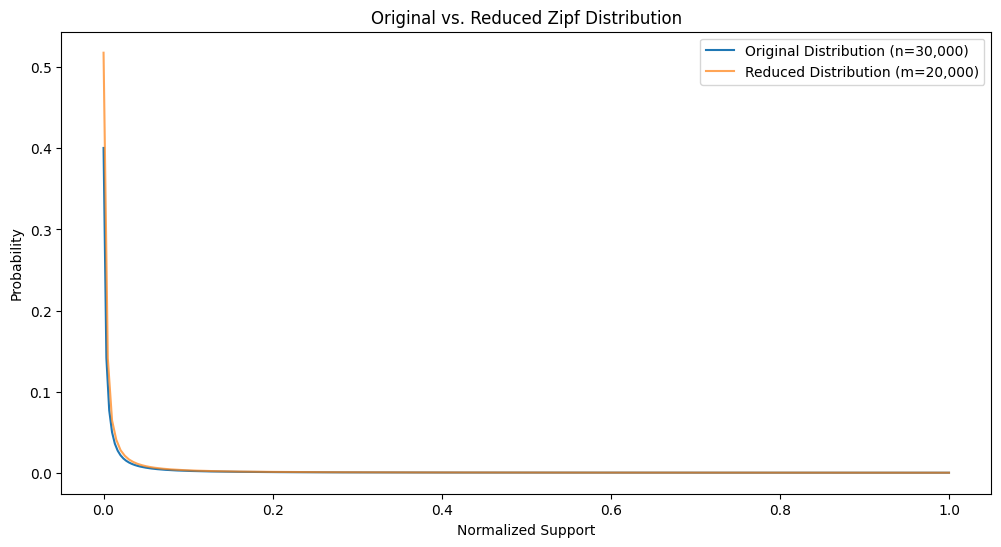

In [7]:
import numpy as np
import time
import matplotlib.pyplot as plt
from scipy.stats import wasserstein_distance

# Function to generate a Zipf's law distribution
def generate_zipf_distribution(n, a=1.5):
    ranks = np.arange(1, n + 1)
    weights = 1 / ranks**a
    distribution = weights / weights.sum()
    return distribution

# Function to reduce the distribution size using interpolation
def reduce_distribution_interpolation(p, m):
    start_time = time.time()
    
    n = len(p)
    # Original support
    x_p = np.linspace(0, 1, n)
    # Target support
    x_q = np.linspace(0, 1, m)
    
    # Interpolate the original distribution to the reduced support
    q = np.interp(x_q, x_p, p)
    # Normalize to ensure q sums to 1
    q /= q.sum()
    
    end_time = time.time()
    runtime = end_time - start_time
    
    return q, x_q, runtime

n = 300  # Original number of entries
m = 200  # Reduced number of entries

# Generate the original Zipf's law distribution
p = generate_zipf_distribution(n)
x_p = np.linspace(0, 1, n)

# Reduce the distribution size
q, x_q, runtime = reduce_distribution_interpolation(p, m)

# Compute the Wasserstein distance using SciPy
wd = wasserstein_distance(x_p, x_q, u_weights=p, v_weights=q)

# Print the results
print(f"Wasserstein distance between original and reduced distributions: {wd}")
print(f"Runtime for reduction: {runtime:.4f} seconds")

# Plot the original and reduced distributions
plt.figure(figsize=(12, 6))
plt.plot(x_p, p, label='Original Distribution (n=30,000)')
plt.plot(x_q, q, label='Reduced Distribution (m=20,000)', alpha=0.7)
plt.xlabel('Normalized Support')
plt.ylabel('Probability')
plt.title('Original vs. Reduced Zipf Distribution')
plt.legend()
plt.show()
